Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (31822, 38)

 Column names:
['Date', 'Location ISO Code', 'Location', 'New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases', 'Location Level', 'City or Regency', 'Province', 'Country', 'Continent', 'Island', 'Time Zone', 'Special Status', 'Total Regencies', 'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 'Area (km2)', 'Population', 'Population Density', 'Longitude', 'Latitude', 'New Cases per Million', 'Total Cases per Million', 'New Deaths per Million', 'Total Deaths per Million', 'Total Deaths per 100rb', 'Case Fatality Rate', 'Case Recovered Rate', 'Growth Factor of New Cases', 'Growth Factor of New Deaths']

 First 5 rows:
       Date Location ISO Code     Location  New Cases  New Deaths  \
0  3/1/2020             ID-JK  DKI J

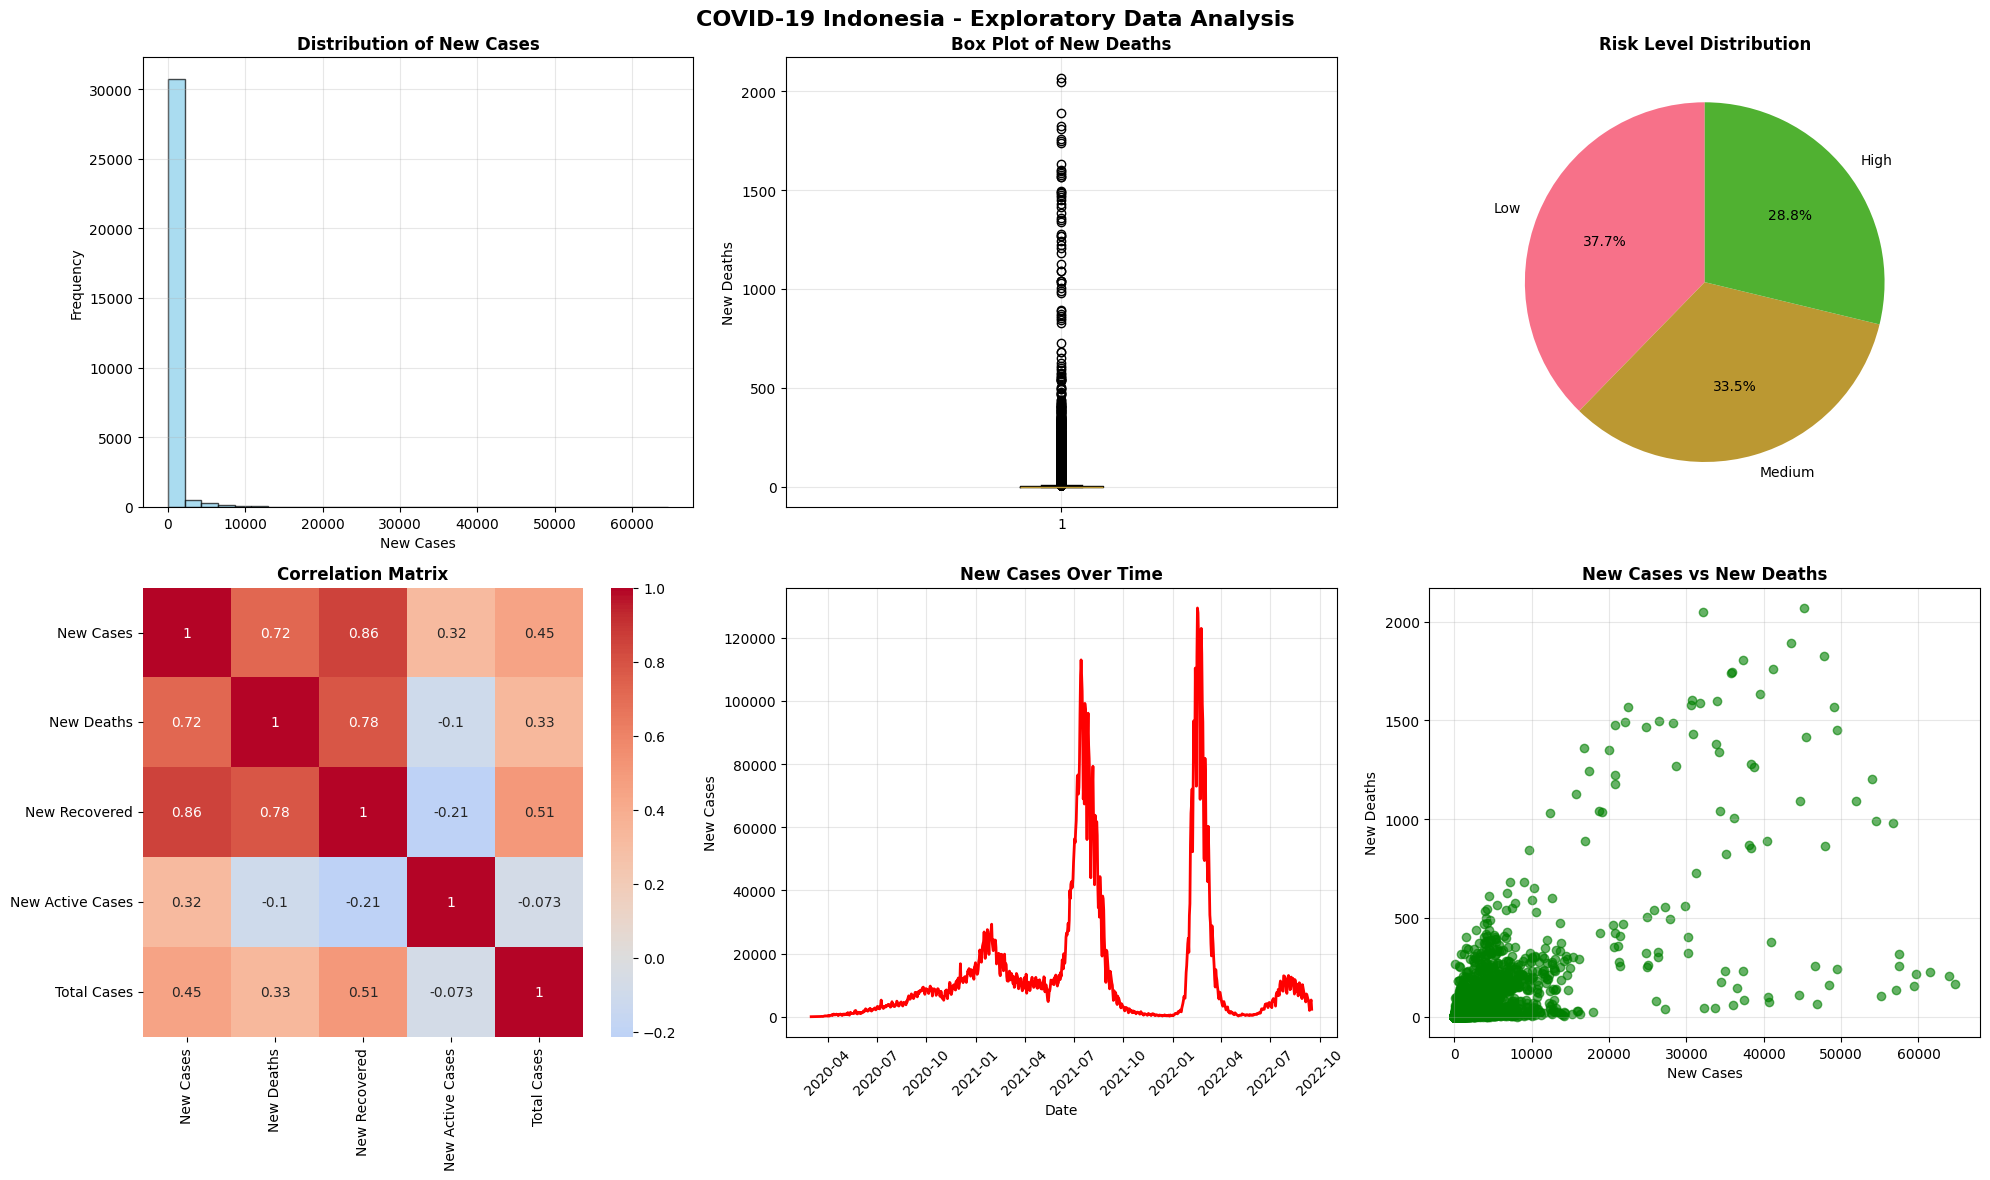


Selected features: ['New Cases', 'New Deaths', 'New Recovered', 'New Active Cases', 'Total Cases', 'Total Deaths', 'Total Recovered', 'Total Active Cases', 'City or Regency', 'Total Regencies', 'Total Cities', 'Total Districts', 'Total Urban Villages', 'Total Rural Villages', 'Area (km2)', 'Population', 'Population Density', 'Longitude', 'Latitude', 'New Cases per Million', 'Total Cases per Million', 'New Deaths per Million', 'Total Deaths per Million', 'Total Deaths per 100rb', 'Growth Factor of New Cases', 'Growth Factor of New Deaths', 'Location ISO Code_encoded', 'Location_encoded', 'Location Level_encoded', 'Province_encoded', 'Country_encoded', 'Continent_encoded', 'Island_encoded', 'Time Zone_encoded', 'Special Status_encoded', 'Case Fatality Rate_encoded', 'Case Recovered Rate_encoded', 'New Cases_New Deaths_ratio', 'New Cases_New Recovered_ratio', 'New Cases_New Active Cases_ratio', 'New Deaths_New Recovered_ratio', 'New Deaths_New Active Cases_ratio', 'New Recovered_New Acti

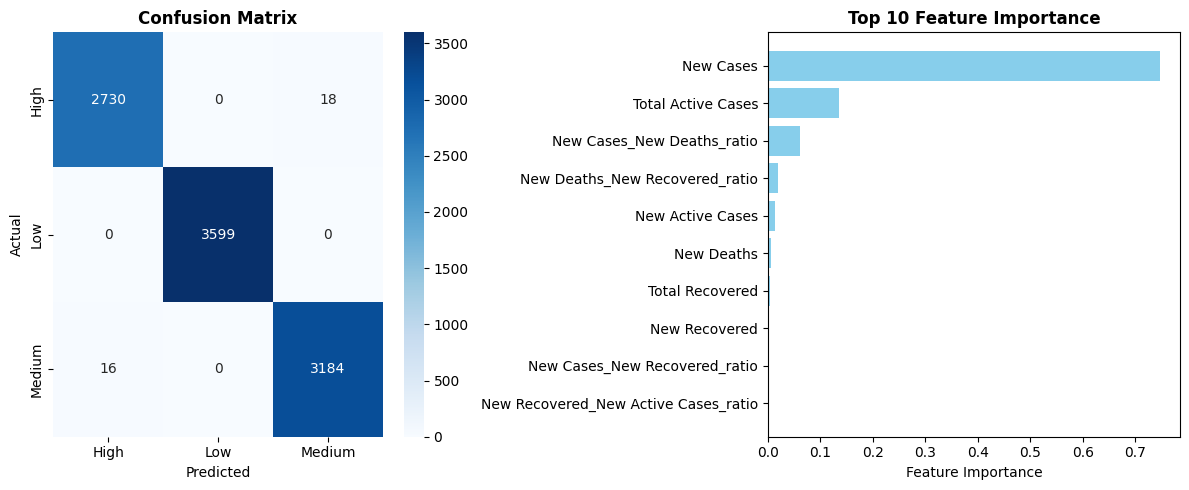

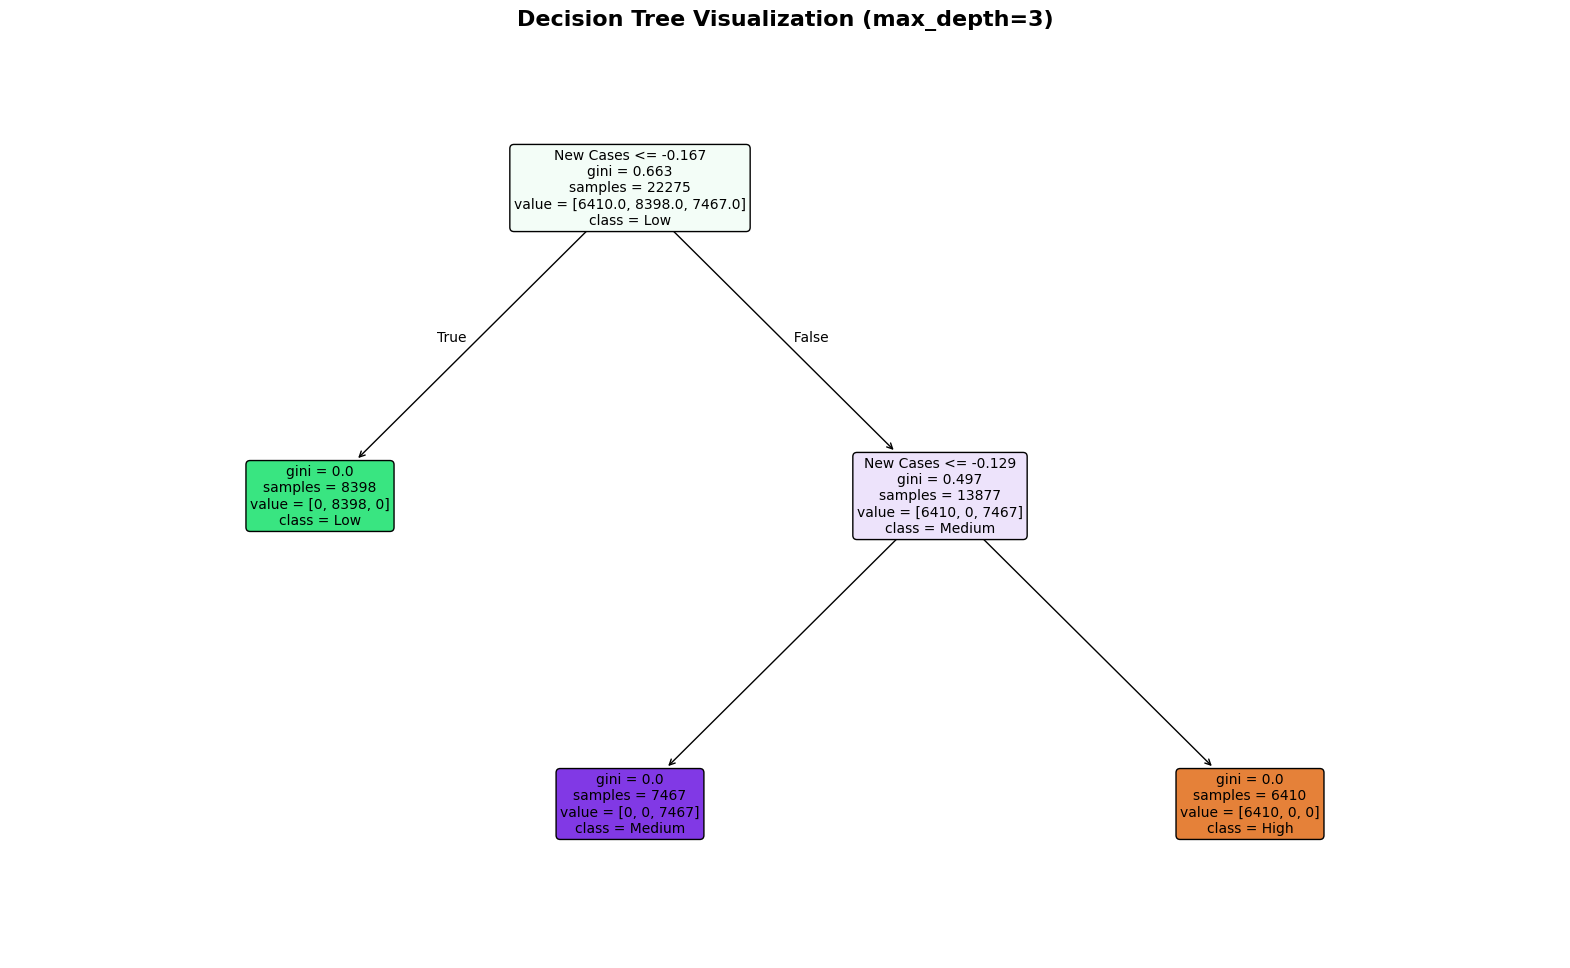


 Decision Tree Rules (simplified):
|--- New Cases <= -0.17
|   |--- class: Low
|--- New Cases >  -0.17
|   |--- New Cases <= -0.13
|   |   |--- class: Medium
|   |--- New Cases >  -0.13
|   |   |--- class: High


 Contoh Prediksi:

Predicted Risk Level: Low
Prediction Probabilities:
   High: 0.0000
   Low: 1.0000
   Medium: 0.0000




In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score)

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# ============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

def load_covid_data():
    try:
        file_path = '/content/drive/MyDrive/Colab Notebooks/iris/covid_19_indonesia_time_series_all.csv'
        df = pd.read_csv(file_path)

        print(f"Dataset shape: {df.shape}")

        # Display basic info
        print(f"\n Column names:")
        print(df.columns.tolist())

        print(f"\n First 5 rows:")
        print(df.head())

        return df

    except Exception as e:
        print(f" Error loading dataset: {str(e)}")
        print("Cek lagi")
        return None

def explore_dataset(df):
    print("\n" + "="*60)
    print(" DATASET EXPLORATION")
    print("="*60)

    print(f"Dataset Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("\n Data Types:")
    print(df.dtypes)

    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])

    print("\n Basic Statistics:")
    print(df.describe())


    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"{col}: {df[col].nunique()} unique values")
            if df[col].nunique() <= 20:
                print(f"  Values: {df[col].unique()}")

df = load_covid_data()
if df is not None:
    explore_dataset(df)

# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def preprocess_data(df):
    print("\n" + "="*60)
    print("="*60)

    df_processed = df.copy()

    if 'Date' in df_processed.columns:
        df_processed['Date'] = pd.to_datetime(df_processed['Date'])

    numeric_columns = []
    for col in df_processed.columns:
        if df_processed[col].dtype in ['int64', 'float64']:
            numeric_columns.append(col)

    print(f" Numeric columns identified: {numeric_columns}")


    for col in numeric_columns:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col] = df_processed[col].fillna(method='ffill')
            print(f"  - Filled missing values in {col}")

    df_processed = df_processed.dropna(how='all')

    if any('cases' in col.lower() for col in df_processed.columns):
        case_columns = [col for col in df_processed.columns if 'cases' in col.lower() or 'case' in col.lower()]

        if case_columns:
            main_case_col = case_columns[0]
            print(f"Using {main_case_col} for target creation")

            df_processed['Risk_Level'] = pd.cut(
                df_processed[main_case_col],
                bins=[-np.inf, 10, 100, np.inf],
                labels=['Low', 'Medium', 'High']
            )
        else:
            print("Tidak ditemukan")
            df_processed['Risk_Level'] = np.random.choice(['Low', 'Medium', 'High'], size=len(df_processed))

    categorical_columns = []
    for col in df_processed.columns:
        if df_processed[col].dtype == 'object' and col != 'Risk_Level':
            categorical_columns.append(col)

    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_processed[col + '_encoded'] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}")

    if len(numeric_columns) >= 2:
        for i, col1 in enumerate(numeric_columns[:3]):
            for col2 in numeric_columns[i+1:4]:
                if col1 != col2:
                    ratio_name = f"{col1}_{col2}_ratio"
                    df_processed[ratio_name] = df_processed[col1] / (df_processed[col2] + 1)  # Add 1 to avoid division by zero

    print(f"📊 Final dataset shape: {df_processed.shape}")

    return df_processed, label_encoders


if df is not None:
    df_processed, label_encoders = preprocess_data(df)

# ============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

def create_eda_visualizations(df):
    print("\n" + "="*60)
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('COVID-19 Indonesia - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numeric_cols) > 0:
        axes[0,0].hist(df[numeric_cols[0]].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title(f'Distribution of {numeric_cols[0]}', fontweight='bold')
        axes[0,0].set_xlabel(numeric_cols[0])
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].grid(True, alpha=0.3)

    if len(numeric_cols) > 1:
        axes[0,1].boxplot(df[numeric_cols[1]].dropna())
        axes[0,1].set_title(f'Box Plot of {numeric_cols[1]}', fontweight='bold')
        axes[0,1].set_ylabel(numeric_cols[1])
        axes[0,1].grid(True, alpha=0.3)

    if 'Risk_Level' in df.columns:
        risk_counts = df['Risk_Level'].value_counts()
        axes[0,2].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0,2].set_title('Risk Level Distribution', fontweight='bold')

    if len(numeric_cols) >= 3:
        correlation_data = df[numeric_cols[:5]].corr()  # Limit to first 5 numeric columns
        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlation Matrix', fontweight='bold')

    if 'Date' in df.columns and len(numeric_cols) > 0:
        df_time = df.groupby('Date')[numeric_cols[0]].sum().reset_index()
        axes[1,1].plot(df_time['Date'], df_time[numeric_cols[0]], color='red', linewidth=2)
        axes[1,1].set_title(f'{numeric_cols[0]} Over Time', fontweight='bold')
        axes[1,1].set_xlabel('Date')
        axes[1,1].set_ylabel(numeric_cols[0])
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)

    if len(numeric_cols) >= 2:
        axes[1,2].scatter(df[numeric_cols[0]], df[numeric_cols[1]], alpha=0.6, color='green')
        axes[1,2].set_title(f'{numeric_cols[0]} vs {numeric_cols[1]}', fontweight='bold')
        axes[1,2].set_xlabel(numeric_cols[0])
        axes[1,2].set_ylabel(numeric_cols[1])
        axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if 'df_processed' in locals():
    create_eda_visualizations(df_processed)

# ============================================================================
# PREPARE DATA FOR MODELING
# ============================================================================

def prepare_modeling_data(df):
    print("\n" + "="*60)
    print("="*60)

    feature_columns = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Risk_Level' in numeric_cols:
        numeric_cols.remove('Risk_Level')

    feature_columns.extend(numeric_cols)

    encoded_cols = [col for col in df.columns if col.endswith('_encoded')]
    feature_columns.extend(encoded_cols)

    feature_columns = [col for col in feature_columns if 'Date' not in col]

    print(f"Selected features: {feature_columns}")

    X = df[feature_columns].copy()

    if 'Risk_Level' in df.columns:
        y = df['Risk_Level'].copy()
        mask = ~y.isna()
        X = X[mask]
        y = y[mask]
    else:
        print("Tidak ditemukan")
        y = np.random.choice(['Low', 'Medium', 'High'], size=len(X))
        y = pd.Series(y)

    X = X.fillna(X.mean())

    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.fillna(X.mean())

    print(f" Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")
    print(f"Class distribution:")
    print(y.value_counts())

    return X, y, feature_columns


# Prepare data for modeling
if 'df_processed' in locals():
    X, y, feature_names = prepare_modeling_data(df_processed)

# ============================================================================
# MACHINE LEARNING MODELING
# ============================================================================

def train_decision_tree(X, y, feature_names):
    print("\n" + "="*60)
    print("DECISION TREE MODELING")
    print("="*60)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    dt_initial = DecisionTreeClassifier(random_state=42)
    dt_initial.fit(X_train_scaled, y_train)

    y_pred_initial = dt_initial.predict(X_test_scaled)
    initial_accuracy = accuracy_score(y_test, y_pred_initial)
    print(f"Initial accuracy: {initial_accuracy:.4f}")

    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10,20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'class_weight': [None, 'balanced'],
        'random_state': [42]
    }

    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train_scaled, y_train)

    best_dt = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    best_dt.fit(X_train_scaled, y_train)
    y_pred_best = best_dt.predict(X_test_scaled)

    return best_dt, X_train_scaled, X_test_scaled, y_train, y_test, y_pred_best, scaler

if 'X' in locals() and 'y' in locals():
    model, X_train, X_test, y_train, y_test, y_pred, scaler = train_decision_tree(X, y, feature_names)

# ============================================================================
# MODEL EVALUATION
# ============================================================================

def evaluate_model(model, X_test, y_test, y_pred, feature_names):
    print("\n" + "="*60)
    print("="*60)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print(f"\nDetail Klasifikasi:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance', fontweight='bold')
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1, feature_importance

if 'model' in locals():
    accuracy, precision, recall, f1, feature_importance = evaluate_model(
        model, X_test, y_test, y_pred, feature_names
    )

# ============================================================================
# DECISION TREE VISUALIZATION
# ============================================================================

def visualize_decision_tree(model, feature_names, max_depth=3):
    print("\n" + "="*60)
    print("="*60)

    simple_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    simple_dt.fit(X_train, y_train)

    plt.figure(figsize=(20, 12))
    plot_tree(simple_dt,
              feature_names=feature_names,
              class_names=simple_dt.classes_,
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f'Decision Tree Visualization (max_depth={max_depth})',
              fontsize=16, fontweight='bold')
    plt.show()

    print(f"\n Decision Tree Rules (simplified):")
    tree_rules = export_text(simple_dt, feature_names=feature_names)
    print(tree_rules[:2000] + "..." if len(tree_rules) > 2000 else tree_rules)

if 'model' in locals():
    visualize_decision_tree(model, feature_names)

# ============================================================================
# MODEL PREDICTION FUNCTION
# ============================================================================

def predict_covid_risk(model, scaler, feature_names, **kwargs):
    print("\n" + "="*60)
    print("="*60)

    input_data = []
    for feature in feature_names:
        if feature in kwargs:
            input_data.append(kwargs[feature])
        else:
            input_data.append(0)

    input_array = np.array(input_data).reshape(1, -1)

    input_scaled = scaler.transform(input_array)

    prediction = model.predict(input_scaled)[0]
    prediction_proba = model.predict_proba(input_scaled)[0]

    print(f"Predicted Risk Level: {prediction}")
    print(f"Prediction Probabilities:")
    for i, class_name in enumerate(model.classes_):
        print(f"   {class_name}: {prediction_proba[i]:.4f}")

    return prediction, prediction_proba

if 'model' in locals():
    print(f"\n Contoh Prediksi:")
    example_input = {}
    for i, feature in enumerate(feature_names[:5]):
        example_input[feature] = float(X_test.iloc[0, i])

    pred, proba = predict_covid_risk(model, scaler, feature_names, **example_input)

# ============================================================================
# SUMMARY AND CONCLUSIONS
# ============================================================================

def print_summary():
    print("\n" + "="*60)
    print("="*60)

    if 'accuracy' in locals():
        print(f"Final Model Performance:")
        print(f"   - Accuracy: {accuracy:.4f}")
        print(f"   - Precision: {precision:.4f}")
        print(f"   - Recall: {recall:.4f}")
        print(f"   - F1-Score: {f1:.4f}")

    if 'feature_importance' in locals():
        print(f"\n Top 5 Most Features Penting:")
        for i, (_, row) in enumerate(feature_importance.head(5).iterrows()):
            print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")



print_summary()


In [ ]:
!wget -O covid_data.csv https://www.kaggle.com/datasets/mexicanpatient/covid19-dataset/download?datasetVersionNumber=2